## Introduction to Data Science Project
## Aequitas

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
import pandas as pd
import numpy as np
import seaborn as sns
import sys


## separando en train, test 
from sklearn.model_selection import train_test_split
## Configuración del RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import random
import pickle

## Análisis Aequitas 
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [134]:
sys.path.append("../..")

### Modules

In [135]:
%load_ext autoreload
%autoreload 2

from src.utils.data_dict import (
    data_dict
)

from src.utils.utils import (
    json_dump_dict,
    load_df
)

from src.utils.params import (
#     param_grid,
#     max_features,
#     n_estimators,
    evaluation_metric,
    feature_importance_theshold,
    tag_non_relevant_cats,
    ingestion_pickle_loc,
    transformation_pickle_loc,
    models_pickle_loc,
    X_train_pickle_loc,
    y_train_pickle_loc,
    X_test_pickle_loc,
    y_test_pickle_loc,
    test_predict_labs_pickle_loc,
    test_predict_scores_pickle_loc,
)

from src.pipelines.ingestion import (
    ingest
)

from src.pipelines.transformation import (
    load_ingestion,
#     date_transformation,
#     hour_transformation,
#     categoric_trasformation,
    transform
)

from src.pipelines.feature_engineering import (
    load_transformation,
    feature_generation,
    feature_selection,
    save_fe,
    feature_engineering,
    fe_pickle_loc_imp_features,
    fe_pickle_loc_feature_labs
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading test results

In [138]:
est_predict_labs = load_df("../../" + test_predict_labs_pickle_loc)
test_predict_scores = load_df("../../" + test_predict_scores_pickle_loc)
y_test = load_df("../../" + y_test_pickle_loc)

In [139]:
y_test.shape

(414942,)

### Construction

In [160]:
dfx = pd.DataFrame(y_test)
dfx["1_prob"] = test_predict_scores[:, 1]
dfx["score"] = dfx["1_prob"].apply(lambda x: 1 if x >= 0.18 else 0)
dfx["correct"] = dfx.apply(lambda x: True if x["label"] == x["score"] else False, axis=1)
dfx

,label,1_prob,score,correct
folio,,,,
C5/190613/06795,0.0,0.149512,0,True
C4/150322/02894,0.0,0.281806,1,False
C5/180302/01135,0.0,0.297361,1,False
C5/190411/07684,0.0,0.146666,0,True
C5/170212/06529,0.0,0.309855,1,False
...,...,...,...,...
C4/140505/00861,0.0,0.133383,0,True
C5/190118/07088,0.0,0.146666,0,True
C5/200814/04440,0.0,0.293350,1,False


Loading raw data:

In [161]:
df_o = pd.read_csv("../../" + "data/incidentes-viales-c5.csv")
df_o.shape

(1383138, 18)

Deleting null values for `delegacion_incio`:

In [162]:
df_o.delegacion_inicio.isnull().sum()

158

In [163]:
df_o.drop(df_o[df_o.delegacion_inicio.isnull()].index, inplace = True)

In [164]:
df_o.shape

(1382980, 18)

In [165]:
df_aeq=pd.merge(dfx, df_o, on='folio', how='left')
df_aeq.shape

(414942, 22)

In [166]:
df_aeq.score.isnull().sum()

0

In [167]:
df_aeq=df_aeq.loc[:, ['folio','label','score','delegacion_inicio']]
df_aeq= df_aeq.rename(columns = {'folio':'entity_id','label': 'label_value'}, inplace = False)

df_aeq.head()

,entity_id,label_value,score,delegacion_inicio
0,C5/190613/06795,0.0,0,COYOACAN
1,C4/150322/02894,0.0,1,GUSTAVO A. MADERO
2,C5/180302/01135,0.0,1,IZTAPALAPA
3,C5/190411/07684,0.0,0,TLAHUAC
4,C5/170212/06529,0.0,1,COYOACAN


In [168]:
df_aeq.delegacion_inicio.unique()

array(['COYOACAN', 'GUSTAVO A. MADERO', 'IZTAPALAPA', 'TLAHUAC',
       'MIGUEL HIDALGO', 'CUAUHTEMOC', 'CUAJIMALPA', 'ALVARO OBREGON',
       'BENITO JUAREZ', 'TLALPAN', 'VENUSTIANO CARRANZA', 'IZTACALCO',
       'XOCHIMILCO', 'MAGDALENA CONTRERAS', 'AZCAPOTZALCO', 'MILPA ALTA',
       nan], dtype=object)

#### EDA test dataset:

**Distribución del score del modelo en las diferentes delegaciones de la variable `delegacion_inicio`:**

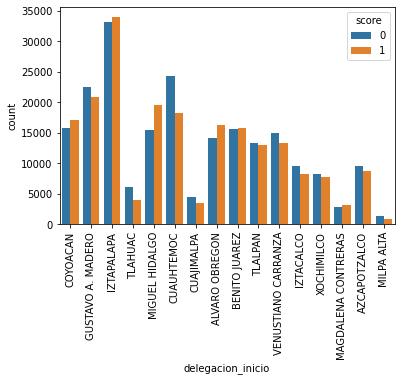

In [169]:
by_del = sns.countplot(x="delegacion_inicio", hue="score", 
                        data=df_aeq[df_aeq.delegacion_inicio.isin(['COYOACAN', 'GUSTAVO A. MADERO', 'IZTAPALAPA', 'TLAHUAC',
       'MIGUEL HIDALGO', 'CUAUHTEMOC', 'CUAJIMALPA', 'ALVARO OBREGON',
       'BENITO JUAREZ', 'TLALPAN', 'VENUSTIANO CARRANZA', 'IZTACALCO',
       'XOCHIMILCO', 'MAGDALENA CONTRERAS', 'AZCAPOTZALCO', 'MILPA ALTA'])])
l=plt.setp(by_del.get_xticklabels(), rotation=90)

**Distribución de las etiquetas de la variable `delegacion_inicio`:**

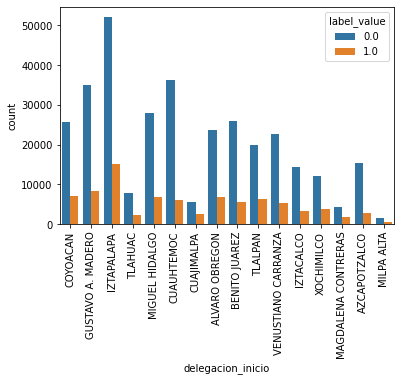

In [170]:
by_del = sns.countplot(x="delegacion_inicio", hue="label_value", 
                        data=df_aeq[df_aeq.delegacion_inicio.isin(['COYOACAN', 'GUSTAVO A. MADERO', 'IZTAPALAPA', 'TLAHUAC',
       'MIGUEL HIDALGO', 'CUAUHTEMOC', 'CUAJIMALPA', 'ALVARO OBREGON',
       'BENITO JUAREZ', 'TLALPAN', 'VENUSTIANO CARRANZA', 'IZTACALCO',
       'XOCHIMILCO', 'MAGDALENA CONTRERAS', 'AZCAPOTZALCO', 'MILPA ALTA'])])
l=plt.setp(by_del.get_xticklabels(), rotation=90)

## Análisis de Aequitas

In [187]:
muestra=df_aeq.sample(n=1000)
muestra.head()

,entity_id,label_value,score,delegacion_inicio
28138,C5/181220/05524,0.0,1.0,VENUSTIANO CARRANZA
132694,C5/191114/07352,1.0,0.0,GUSTAVO A. MADERO
392199,C4/150117/05042,0.0,1.0,BENITO JUAREZ
33728,C5/200305/07071,1.0,0.0,TLAHUAC
325893,C5/181011/00836,0.0,0.0,MIGUEL HIDALGO


In [243]:
g = Group()
xtab, attrbs = g.get_crosstabs(df_aeq)

model_id, score_thresholds 0 {'rank_abs': [203773]}


Tabla de crosstabs

In [244]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,...,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,203773,delegacion_inicio,ALVARO OBREGON,...,6814,23637,30451,414942,0.223769
1,0,binary 0/1,203773,delegacion_inicio,AZCAPOTZALCO,...,2923,15321,18244,414942,0.160217
2,0,binary 0/1,203773,delegacion_inicio,BENITO JUAREZ,...,5462,25965,31427,414942,0.173800
3,0,binary 0/1,203773,delegacion_inicio,COYOACAN,...,7140,25692,32832,414942,0.217471
4,0,binary 0/1,203773,delegacion_inicio,CUAJIMALPA,...,2507,5481,7988,414942,0.313846
5,0,binary 0/1,203773,delegacion_inicio,CUAUHTEMOC,...,6176,36341,42517,414942,0.145260
6,0,binary 0/1,203773,delegacion_inicio,GUSTAVO A. MADERO,...,8382,34913,43295,414942,0.193602
7,0,binary 0/1,203773,delegacion_inicio,IZTACALCO,...,3311,14459,17770,414942,0.186325
8,0,binary 0/1,203773,delegacion_inicio,IZTAPALAPA,...,15025,52101,67126,414942,0.223833
9,0,binary 0/1,203773,delegacion_inicio,MAGDALENA CONTRERAS,...,1708,4280,5988,414942,0.285237


In [245]:
attrbs

Index(['delegacion_inicio'], dtype='object')

In [246]:
absolute_metrics = g.list_absolute_metrics(xtab)

Conteos por grupo:

In [247]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,...,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,203773,delegacion_inicio,ALVARO OBREGON,...,4854,6814,23637,30451,414942
1,0,binary 0/1,203773,delegacion_inicio,AZCAPOTZALCO,...,1937,2923,15321,18244,414942
2,0,binary 0/1,203773,delegacion_inicio,BENITO JUAREZ,...,3971,5462,25965,31427,414942
3,0,binary 0/1,203773,delegacion_inicio,COYOACAN,...,5199,7140,25692,32832,414942
4,0,binary 0/1,203773,delegacion_inicio,CUAJIMALPA,...,1437,2507,5481,7988,414942
5,0,binary 0/1,203773,delegacion_inicio,CUAUHTEMOC,...,4029,6176,36341,42517,414942
6,0,binary 0/1,203773,delegacion_inicio,GUSTAVO A. MADERO,...,5820,8382,34913,43295,414942
7,0,binary 0/1,203773,delegacion_inicio,IZTACALCO,...,2180,3311,14459,17770,414942
8,0,binary 0/1,203773,delegacion_inicio,IZTAPALAPA,...,10510,15025,52101,67126,414942
9,0,binary 0/1,203773,delegacion_inicio,MAGDALENA CONTRERAS,...,1211,1708,4280,5988,414942


Cálculo de las métricas absolutas por grupo:

In [248]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

,attribute_name,attribute_value,tpr,tnr,for,...,npv,precision,ppr,pprev,prev
0,delegacion_inicio,ALVARO OBREGON,0.71,0.52,0.14,...,0.86,0.30,0.08,0.54,0.22
1,delegacion_inicio,AZCAPOTZALCO,0.66,0.56,0.10,...,0.90,0.22,0.04,0.48,0.16
2,delegacion_inicio,BENITO JUAREZ,0.73,0.54,0.10,...,0.90,0.25,0.08,0.50,0.17
3,delegacion_inicio,COYOACAN,0.73,0.54,0.12,...,0.88,0.30,0.08,0.52,0.22
4,delegacion_inicio,CUAJIMALPA,0.57,0.62,0.24,...,0.76,0.41,0.02,0.44,0.31
5,delegacion_inicio,CUAUHTEMOC,0.65,0.61,0.09,...,0.91,0.22,0.09,0.43,0.15
6,delegacion_inicio,GUSTAVO A. MADERO,0.69,0.57,0.11,...,0.89,0.28,0.10,0.48,0.19
7,delegacion_inicio,IZTACALCO,0.66,0.58,0.12,...,0.88,0.26,0.04,0.47,0.19
8,delegacion_inicio,IZTAPALAPA,0.70,0.55,0.14,...,0.86,0.31,0.17,0.51,0.22
9,delegacion_inicio,MAGDALENA CONTRERAS,0.71,0.56,0.17,...,0.83,0.39,0.02,0.52,0.29


#### Interpretación:

Hola

### Bias

In [249]:
aeq = Plot()

De las llamadas falsas, observamos cuál es la probabilidad de que haya sido verdadera, de acuerdo con la delegación, a través de la False Discovery Rate.

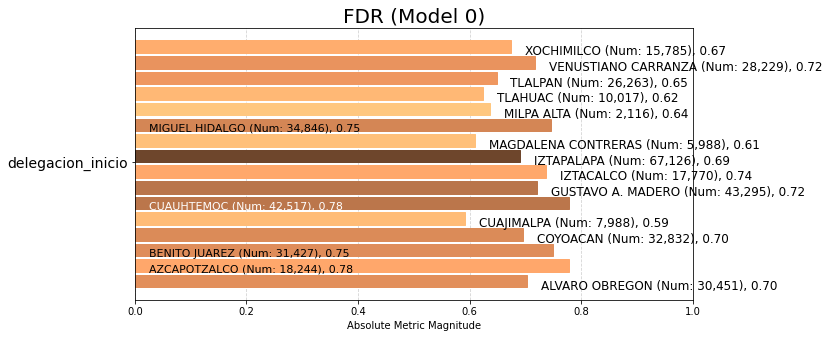

In [250]:
fdr = aeq.plot_group_metric(xtab, 'fdr')

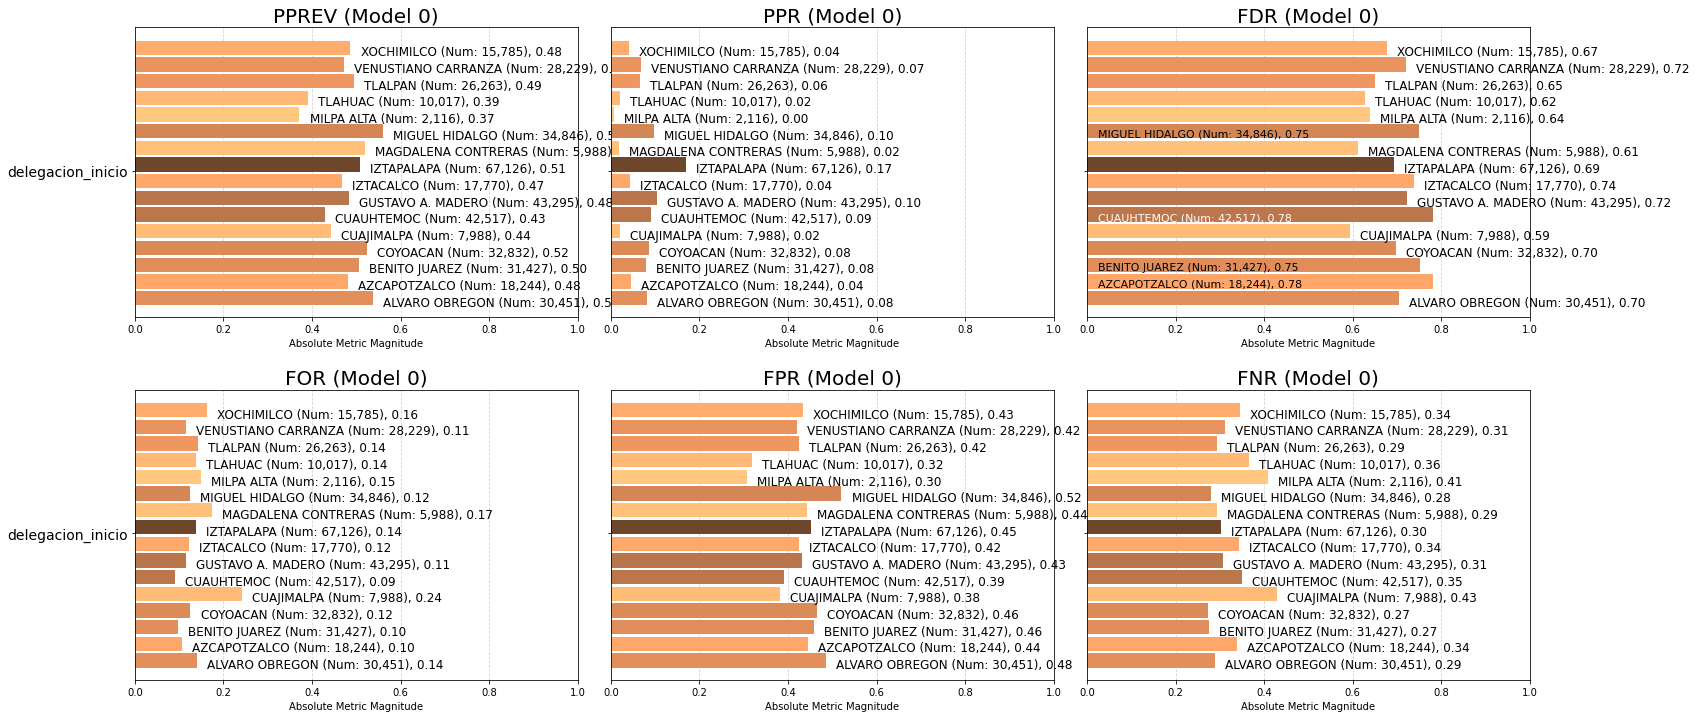

<Figure size 432x288 with 0 Axes>

In [251]:
p = aeq.plot_group_metric_all(xtab)#, metrics=['ppr','fdr','fpr'])

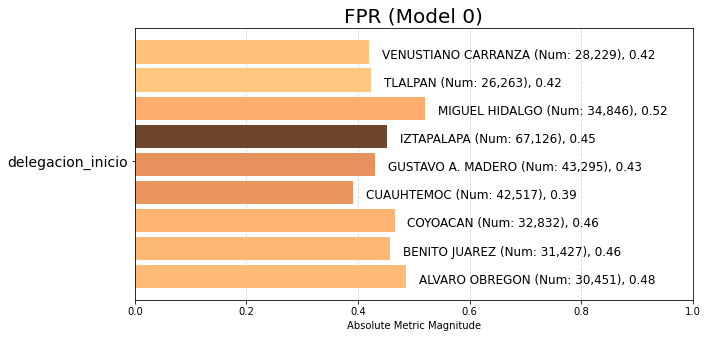

In [252]:
fnr = aeq.plot_group_metric(xtab, 'fpr', min_group_size=0.05)

Calculo las disparidades entre los diferentes grupos por cada métrica de interés:

In [253]:
bias = Bias()

In [254]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=df_aeq, 
                                        ref_groups_dict={'delegacion_inicio':'IZTAPALAPA'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)

get_disparity_predefined_group()


In [255]:
bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf)].round(2)

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,...,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity
0,delegacion_inicio,ALVARO OBREGON,1.02,0.96,1.02,...,0.48,1.06,0.96,0.94,1.02
1,delegacion_inicio,AZCAPOTZALCO,1.13,1.12,0.76,...,0.26,0.95,0.72,1.01,0.95
2,delegacion_inicio,BENITO JUAREZ,1.08,0.91,0.70,...,0.47,1.00,0.81,0.99,1.04
3,delegacion_inicio,COYOACAN,1.01,0.90,0.91,...,0.50,1.03,0.98,0.97,1.04
4,delegacion_inicio,CUAJIMALPA,0.86,1.42,1.76,...,0.10,0.87,1.32,1.13,0.82
5,delegacion_inicio,CUAUHTEMOC,1.13,1.16,0.65,...,0.54,0.85,0.72,1.11,0.93
6,delegacion_inicio,GUSTAVO A. MADERO,1.04,1.02,0.84,...,0.61,0.95,0.90,1.04,0.99
7,delegacion_inicio,IZTACALCO,1.07,1.14,0.88,...,0.24,0.92,0.85,1.05,0.94
8,delegacion_inicio,IZTAPALAPA,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00
9,delegacion_inicio,MAGDALENA CONTRERAS,0.88,0.97,1.26,...,0.09,1.02,1.26,1.02,1.01


In [256]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=df_aeq)

get_disparity_major_group()


In [257]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,...,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion_inicio,ALVARO OBREGON,0.48,1.06,0.96,...,1.08,0.96,1.02,0.94,1.00
1,delegacion_inicio,AZCAPOTZALCO,0.26,0.95,0.72,...,0.99,1.12,0.95,1.01,1.04
2,delegacion_inicio,BENITO JUAREZ,0.47,1.00,0.81,...,1.01,0.91,1.04,0.99,1.05
3,delegacion_inicio,COYOACAN,0.50,1.03,0.98,...,1.03,0.90,1.04,0.97,1.01
4,delegacion_inicio,CUAJIMALPA,0.10,0.87,1.32,...,0.85,1.42,0.82,1.13,0.88
5,delegacion_inicio,CUAUHTEMOC,0.54,0.85,0.72,...,0.87,1.16,0.93,1.11,1.06
6,delegacion_inicio,GUSTAVO A. MADERO,0.61,0.95,0.90,...,0.96,1.02,0.99,1.04,1.03
7,delegacion_inicio,IZTACALCO,0.24,0.92,0.85,...,0.94,1.14,0.94,1.05,1.02
8,delegacion_inicio,IZTAPALAPA,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00
9,delegacion_inicio,MAGDALENA CONTRERAS,0.09,1.02,1.26,...,0.98,0.97,1.01,1.02,0.96


In [258]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=df_aeq)

get_disparity_min_metric()


In [259]:
min_bdf[['attribute_name', 'attribute_value'] + bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,...,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion_inicio,ALVARO OBREGON,20.84,1.45,1.34,...,1.59,1.06,1.24,1.07,1.13
1,delegacion_inicio,AZCAPOTZALCO,11.17,1.30,1.00,...,1.46,1.24,1.16,1.16,1.18
2,delegacion_inicio,BENITO JUAREZ,20.21,1.36,1.13,...,1.50,1.00,1.27,1.13,1.19
3,delegacion_inicio,COYOACAN,21.88,1.41,1.37,...,1.52,1.00,1.27,1.11,1.15
4,delegacion_inicio,CUAJIMALPA,4.50,1.19,1.84,...,1.25,1.57,1.00,1.29,1.00
5,delegacion_inicio,CUAUHTEMOC,23.24,1.16,1.00,...,1.28,1.28,1.14,1.27,1.20
6,delegacion_inicio,GUSTAVO A. MADERO,26.61,1.30,1.26,...,1.41,1.12,1.21,1.18,1.17
7,delegacion_inicio,IZTACALCO,10.59,1.26,1.19,...,1.39,1.26,1.15,1.20,1.16
8,delegacion_inicio,IZTAPALAPA,43.39,1.37,1.40,...,1.48,1.11,1.22,1.14,1.14
9,delegacion_inicio,MAGDALENA CONTRERAS,3.96,1.40,1.76,...,1.45,1.07,1.24,1.16,1.09


### Visualización de disparidades:

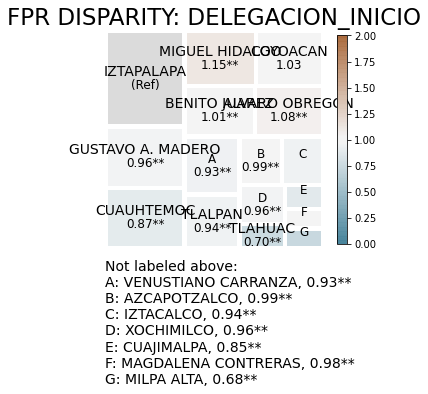

In [260]:
fpr_disparity = aeq.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='delegacion_inicio', 
                                   significance_alpha=0.05)

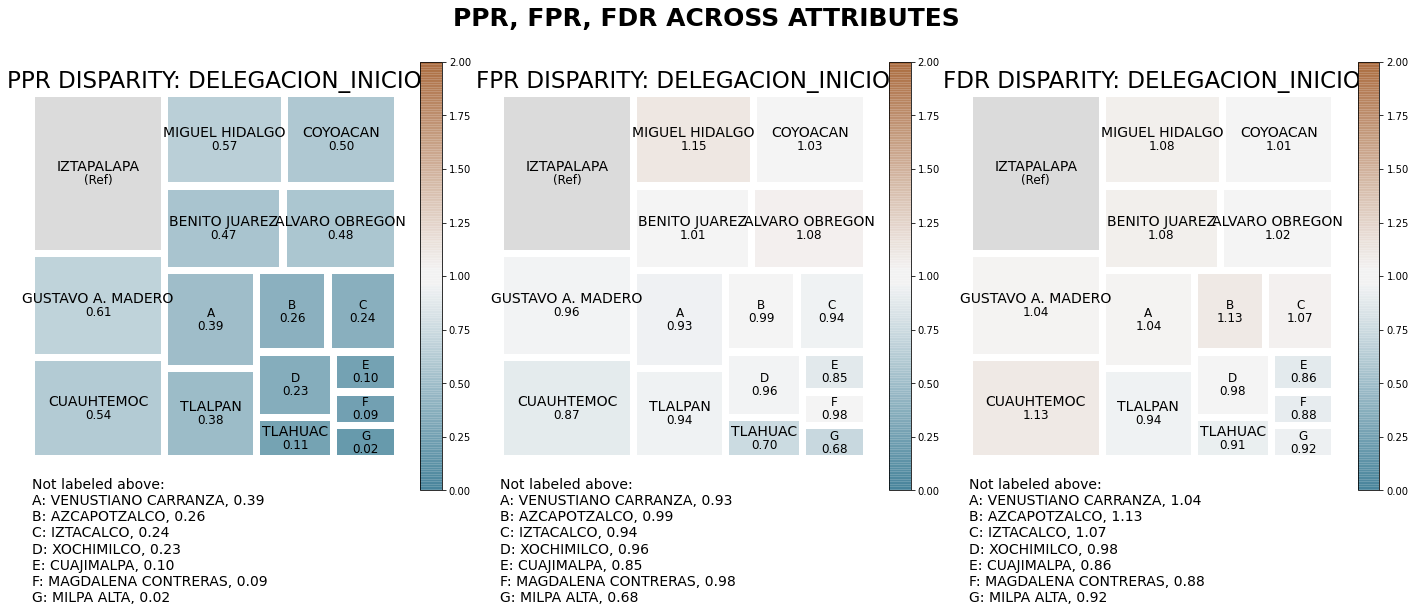

In [261]:
p = aeq.plot_disparity_all(majority_bdf,  metrics=['ppr','fpr','fdr'], significance_alpha=0.05)

### Fairness

Equidad a nivel grupo:

In [262]:
fair = Fairness()

In [263]:
fdf = fair.get_group_value_fairness(bdf)

In [264]:
parity_determinations = fair.list_parities(fdf)

In [265]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,...,NPV Parity,FNR Parity,FDR Parity,Unsupervised Fairness,Supervised Fairness
0,delegacion_inicio,ALVARO OBREGON,0.71,0.52,0.14,...,True,True,True,False,True
1,delegacion_inicio,AZCAPOTZALCO,0.66,0.56,0.10,...,True,True,True,False,False
2,delegacion_inicio,BENITO JUAREZ,0.73,0.54,0.10,...,True,True,True,False,False
3,delegacion_inicio,COYOACAN,0.73,0.54,0.12,...,True,True,True,False,True
4,delegacion_inicio,CUAJIMALPA,0.57,0.62,0.24,...,True,False,True,False,False
5,delegacion_inicio,CUAUHTEMOC,0.65,0.61,0.09,...,True,True,True,False,False
6,delegacion_inicio,GUSTAVO A. MADERO,0.69,0.57,0.11,...,True,True,True,False,True
7,delegacion_inicio,IZTACALCO,0.66,0.58,0.12,...,True,True,True,False,True
8,delegacion_inicio,IZTAPALAPA,0.70,0.55,0.14,...,True,True,True,True,True
9,delegacion_inicio,MAGDALENA CONTRERAS,0.71,0.56,0.17,...,True,True,True,False,False


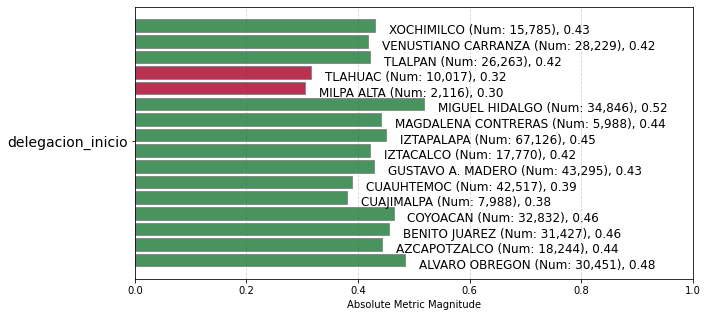

In [266]:
z = aeq.plot_fairness_group(fdf, group_metric='fpr')

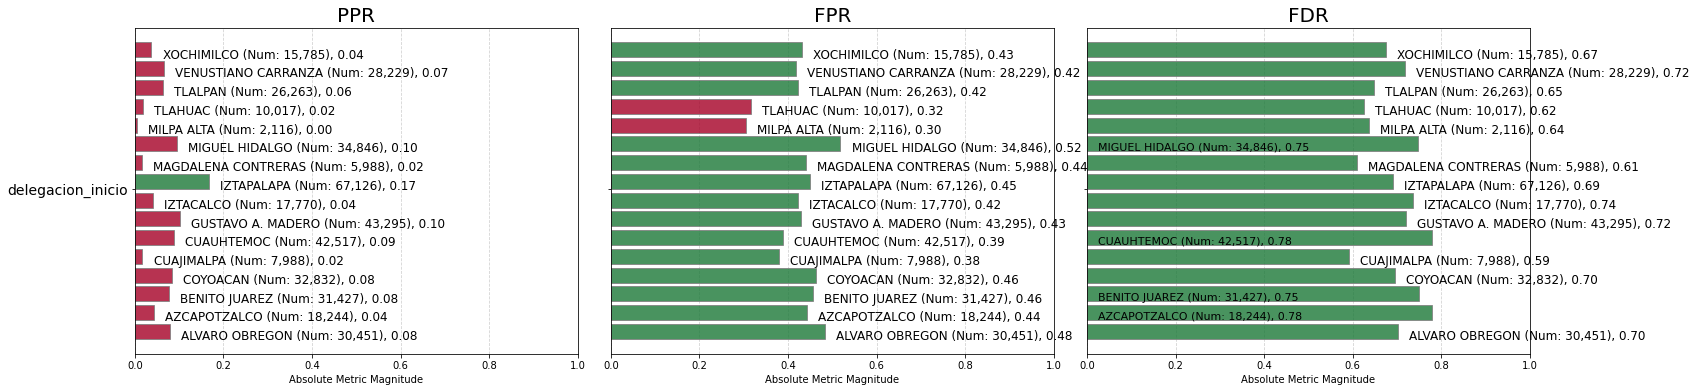

<Figure size 432x288 with 0 Axes>

In [267]:
z = aeq.plot_fairness_group_all(fdf, metrics=['ppr','fpr','fdr'])

Equidad a nivel atributo:

In [268]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,...,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion_inicio,False,False,...,False,False,False,False,False


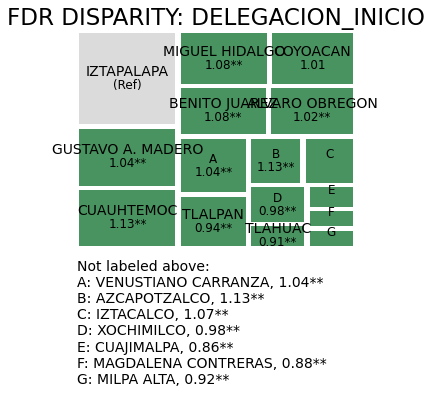

In [269]:
m = aeq.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='delegacion_inicio')

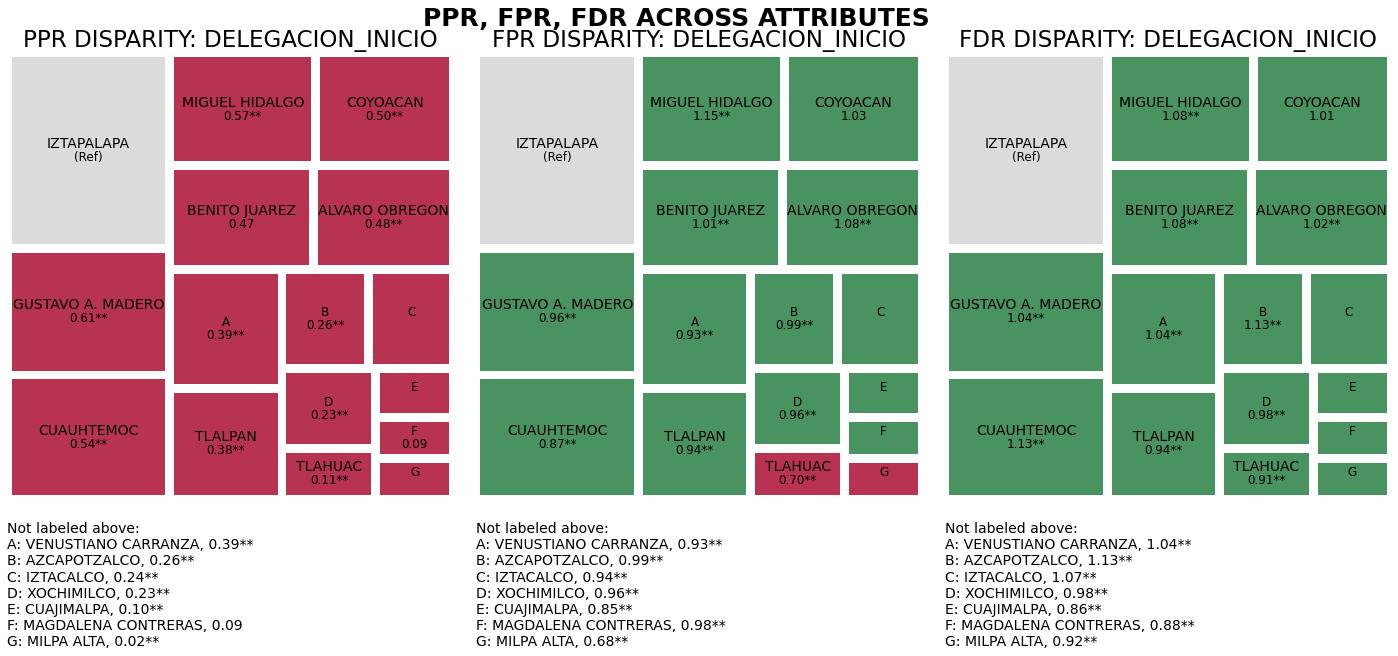

In [270]:
m = aeq.plot_fairness_disparity_all(fdf, metrics=['ppr','fpr','fdr'])

Equidad overall:

In [271]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,...,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,203773,delegacion_inicio,ALVARO OBREGON,...,True,True,True,False,True
1,0,binary 0/1,203773,delegacion_inicio,AZCAPOTZALCO,...,True,False,True,False,False
2,0,binary 0/1,203773,delegacion_inicio,BENITO JUAREZ,...,True,False,True,False,False
3,0,binary 0/1,203773,delegacion_inicio,COYOACAN,...,True,True,True,False,True
4,0,binary 0/1,203773,delegacion_inicio,CUAJIMALPA,...,True,False,True,False,False
5,0,binary 0/1,203773,delegacion_inicio,CUAUHTEMOC,...,True,False,True,False,False
6,0,binary 0/1,203773,delegacion_inicio,GUSTAVO A. MADERO,...,True,True,True,False,True
7,0,binary 0/1,203773,delegacion_inicio,IZTACALCO,...,True,True,True,False,True
8,0,binary 0/1,203773,delegacion_inicio,IZTAPALAPA,...,True,True,True,True,True
9,0,binary 0/1,203773,delegacion_inicio,MAGDALENA CONTRERAS,...,True,False,True,False,False


In [272]:
gof = fair.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}